# Mixture info constraint Removed

In [1]:
import numpy as np
import os
import librosa as lb
import soundfile as sf
import museval
from matplotlib import pyplot as plt
from tqdm import tqdm
import librosa.display

In [2]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [3]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [4]:
def spectra(X, S, outpath):
    
    stft_bv = lb.stft(X[0])
    stft_bb = lb.stft(X[1])
    stft_bd = lb.stft(X[2])
    stft_bo = lb.stft(X[3])
    
    stft_vp = lb.stft(S[0])
    stft_bp = lb.stft(S[1])
    stft_dp = lb.stft(S[2])
    stft_op = lb.stft(S[3])
    
    
    fig, ax = plt.subplots()
    img = librosa.display.specshow(np.abs(stft_vp), x_axis='time', y_axis='log', ax=ax)
    ax.set(title='Vocal Predicted')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    #plt.savefig(outpath+'VocalpredictedSpect.png')
    
    fig, ax = plt.subplots()
    img = librosa.display.specshow(np.abs(stft_bv), x_axis='time', y_axis='log', ax=ax)
    ax.set(title='Vocal Bleed')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    #plt.savefig(outpath+'VocalBleedSpect.png')

In [5]:
def updateA(X, S):
    
    n, l = X.shape
    I = np.eye(n)
    regularizer = 0.00001
    
    XST = X @ S.T
    SST = S @ S.T
    F1 = (XST + regularizer*I)
    F2 = (SST + regularizer*I)
    F2_inv = np.linalg.inv(F2)
    A = F1 @ F2_inv
    return A

In [8]:
def updateS(X, A):
    n, l = X.shape
    ATA = A.T @ A
    ATX = A.T @ X
    ATA_inv = np.linalg.inv(ATA)
    S = ATA_inv @ ATX
    return S

In [9]:
def objective(X, A, S):
    return np.linalg.norm(X-(A@S))**2

In [10]:
def project(A, gamma1, gamma2):
    n, _ = A.shape
    for i in range(n):
        for j in range(n):
            if i!=j:
                if A[i][j] > gamma2:
                    A[i][j] = gamma2
                if A[i][j] < gamma1:
                    A[i][j] = gamma1
            else:
                #pass
                #A[i][j] = 1
                
                if A[i][j] > 1:
                    A[i][j] = 1
                elif A[i][j] < 0.75:
                    A[i][j] = 0.75      
                
    return A

In [29]:
def Minimize(X, m, gamma1, gamma2, tol=1e-3, max_iter=1000):
    n, l = X.shape
    A = np.eye(n)
    S_opt = X.copy()
    #A = A + 0.001*np.ones(n)
    #A = np.random.random((n, n))
    #S_opt = np.random.random((n, l))

    iters = 0
    while True:
        
        A_opt = updateA(X, S_opt)
        A_opt = project(A_opt, gamma1, gamma2)
        S_opt = updateS(X, A_opt)
        loss = objective(X, A_opt, S_opt)
        #print('ITERATION:', iters+1, 'LOSS:', loss, sep=' ')
        if iters>0 and (prev_loss - loss) <= tol:
            break
        prev_loss = loss
        iters +=1
        if iters >= max_iter:
            print('MAXIMUM ITERATION REACHED!!!')
            break
        
    return A_opt, S_opt

In [30]:
def bleed_remove(clean_path, outpath):
    vocals, fs = lb.load(clean_path+'tvocals.wav')
    bass, fs = lb.load(clean_path+'tbass.wav')
    drums, fs = lb.load(clean_path+'tdrums.wav')
    other, fs = lb.load(clean_path+'tother.wav')

    smix, fs = lb.load(clean_path+'smix.wav')
    xmix, fs = lb.load(clean_path+'xmix.wav')
    
    bvocals, fs = lb.load(clean_path+'bvocals.wav')
    bbass, fs = lb.load(clean_path+'bbass.wav')
    bdrums, fs = lb.load(clean_path+'bdrums.wav')
    bother, fs = lb.load(clean_path+'bother.wav')

    mixture, fs = lb.load(clean_path+'mixture.wav')
    
    X = np.array([bvocals, bbass, bdrums, bother])
    S = np.array([vocals, bass, drums, other])
    m = np.array([mixture]) #NOTE HERE
    
    #O = (m @ np.linalg.pinv(S)).T
    #O = np.array([np.ones(4)]).T
    
    block = 25
    A_pred, S_pred = [], []

    for i in tqdm(range(0, X.shape[1], block)):
        x_ = X[:, i:i+block]
        m_ = m[:, i:i+block]
        A_opt, S_opt = Minimize(x_, m_, 0.0001, 1, tol=1e-6)
        S_pred.append(S_opt)
        A_pred.append(A_opt)

    S_pred = np.hstack(S_pred)
    
    sf.write(outpath+'pred_vocal.wav', S_pred[0], fs)
    sf.write(outpath+'pred_bass.wav', S_pred[1], fs)
    sf.write(outpath+'pred_drums.wav', S_pred[2], fs)
    sf.write(outpath+'pred_others.wav', S_pred[3], fs)
    
    tv_sdr = compute_sdr(vocals, bvocals, fs)
    tb_sdr = compute_sdr(bass, bbass, fs)
    td_sdr = compute_sdr(drums, bdrums, fs)
    to_sdr = compute_sdr(other, bother, fs)

    true_sdr = (tv_sdr + tb_sdr + td_sdr + to_sdr)/4
    print(true_sdr, tv_sdr, tb_sdr, td_sdr, to_sdr)
    
    v_sdr = compute_sdr(vocals, S_pred[0], fs)
    b_sdr = compute_sdr(bass, S_pred[1], fs)
    d_sdr = compute_sdr(drums, S_pred[2], fs)
    o_sdr = compute_sdr(other, S_pred[3], fs)

    obtained_sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
    print(obtained_sdr, v_sdr, b_sdr, d_sdr, o_sdr)
    
    A_avg = np.average(A_pred, axis=0)
    print(np.round(A_avg, 3))
    
    A_act = X @ np.linalg.pinv(S)
    print(np.round(A_act, 3))
    print(np.linalg.norm(A_act - A_avg)**2)
    
    spectra(X, S, outpath)
    
    return np.array(A_pred)

In [31]:
clean_path = "/home/rajesh/Desktop/"
outpath = "/home/rajesh/Desktop/"

100%|██████████████████████████████████████████████████████████| 8820/8820 [00:02<00:00, 3865.11it/s]


14.595733322679685 15.43875191468301 15.29993773842494 17.982826757980256 9.66141687963054
14.606207033492684 15.449191967540624 15.310422831047656 17.993303112851763 9.671910222530695
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1.  0.1 0.1 0.1]
 [0.1 1.  0.1 0.1]
 [0.1 0.1 1.  0.1]
 [0.1 0.1 0.1 1. ]]
0.1197594640521305


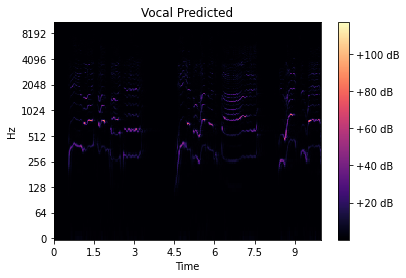

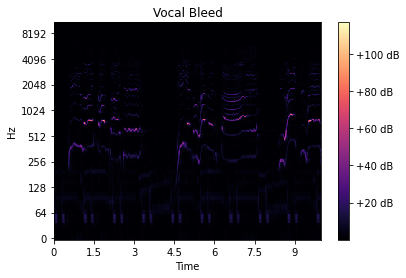

In [32]:
A_pred = bleed_remove(clean_path, outpath)

In [33]:
np.round(A_pred, 4)

array([[[1.e+00, 1.e-04, 1.e-04, 1.e-04],
        [1.e-04, 1.e+00, 1.e-04, 1.e-04],
        [1.e-04, 1.e-04, 1.e+00, 1.e-04],
        [1.e-04, 1.e-04, 1.e-04, 1.e+00]],

       [[1.e+00, 1.e-04, 1.e-04, 1.e-04],
        [1.e-04, 1.e+00, 1.e-04, 1.e-04],
        [1.e-04, 1.e-04, 1.e+00, 1.e-04],
        [1.e-04, 1.e-04, 1.e-04, 1.e+00]],

       [[1.e+00, 1.e-04, 1.e-04, 1.e-04],
        [1.e-04, 1.e+00, 1.e-04, 1.e-04],
        [1.e-04, 1.e-04, 1.e+00, 1.e-04],
        [1.e-04, 1.e-04, 1.e-04, 1.e+00]],

       ...,

       [[1.e+00, 1.e-04, 1.e-04, 1.e-04],
        [1.e-04, 1.e+00, 1.e-04, 1.e-04],
        [1.e-04, 1.e-04, 1.e+00, 1.e-04],
        [1.e-04, 1.e-04, 1.e-04, 1.e+00]],

       [[1.e+00, 1.e-04, 1.e-04, 1.e-04],
        [1.e-04, 1.e+00, 1.e-04, 1.e-04],
        [1.e-04, 1.e-04, 1.e+00, 1.e-04],
        [1.e-04, 1.e-04, 1.e-04, 1.e+00]],

       [[1.e+00, 1.e-04, 1.e-04, 1.e-04],
        [1.e-04, 1.e+00, 1.e-04, 1.e-04],
        [1.e-04, 1.e-04, 1.e+00, 1.e-04],
        [1.